# Create corpus. Define and train Doc2Vec models.
In the process, latest wikipedia dump will be loaded. From dump, a corpus of documents/articles will be constructed. After that, Doc2vec models will be defined and trained on corpus.

In case of running notebook on Google Colab environment with Google Drive storage:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# replace path with parent directory of current notebook
%cd /content/drive/MyDrive/Colab\ Notebooks/s2v_d2v/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/s2v_d2v


Use gensim > 4.0.0 to ensure that the models can be opened in newest version.

In [ ]:
!ls -l

total 61
-rw------- 1 root root 61822 Aug  1 14:39 doc2vec_models_s2v.ipynb
-rw------- 1 root root   174 Jul 19 10:54 requirements.txt


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.7 MB 20.2 MB/s 
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
     |████████████████████████████████| 5.8 MB 54.5 MB/s 
     |████████████████████████████████| 660 kB 77.8 MB/s 
     |████████████████████████████████| 10.1 MB 67.4 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.0.0-py3-none-any.whl size=13704318 sha256=bb5fd0e4a39cd90f148b3c2095c35a53a5bd65946d4590b7d2d2ef8eae14957b
  Stored in directory: /root/.cache/pip/wheels/2d/86/ba/c33ceff8af5cb8a963e86131912039d39b37227f9787661bca
Successfully built en-core-web-sm
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: typer
    Found existing installation: typer 0.4.2
    Uninstalling typer-0.4.2

## Create documents corpus
Construct a corpus from a Wikipedia database dump.

In [ ]:
import smart_open
from gensim.corpora.wikicorpus import WikiCorpus, tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
import os
import logging
import multiprocessing
import tarfile

Download latest wiki dump:

In [ ]:
# path_to_source = 'https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2'
path_to_source = 'https://dumps.wikimedia.org/enwiki/latest/\
enwiki-latest-pages-articles-multistream9.xml-p2936261p4045402.bz2'

In [ ]:
!wget $path_to_source

--2022-08-01 14:39:58--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles-multistream9.xml-p2936261p4045402.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 559587726 (534M) [application/octet-stream]
Saving to: ‘enwiki-latest-pages-articles-multistream9.xml-p2936261p4045402.bz2’

enwiki-latest-pages 100%[===================>] 533.66M  4.01MB/s    in 2m 5s   

2022-08-01 14:42:03 (4.26 MB/s) - ‘enwiki-latest-pages-articles-multistream9.xml-p2936261p4045402.bz2’ saved [559587726/559587726]



Compressed dump file:

In [ ]:
dump_filename = path_to_source.split('/')[-1]
print(dump_filename)

enwiki-latest-pages-articles-multistream9.xml-p2936261p4045402.bz2


Check dump:

In [ ]:
with smart_open.open(dump_filename, "r", encoding='utf8') as file:
    for i in range(156):
        print(file.readline())

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">

  <siteinfo>

    <sitename>Wikipedia</sitename>

    <dbname>enwiki</dbname>

    <base>https://en.wikipedia.org/wiki/Main_Page</base>

    <generator>MediaWiki 1.39.0-wmf.19</generator>

    <case>first-letter</case>

    <namespaces>

      <namespace key="-2" case="first-letter">Media</namespace>

      <namespace key="-1" case="first-letter">Special</namespace>

      <namespace key="0" case="first-letter" />

      <namespace key="1" case="first-letter">Talk</namespace>

      <namespace key="2" case="first-letter">User</namespace>

      <namespace key="3" case="first-letter">User talk</namespace>

      <namespace key="4" case="first-letter">Wikipedia</namespace>

      <namespace key="5" case="first-letter">Wikipedia talk</name

Create WikiCorpus object. It's only object, wiki.get_texts() - iterator

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_custom(text, token_min_len, token_max_len, lower):
    #override original method in wikicorpus.py
    #return [utils.to_unicode(token) for token in utils.tokenize(text, lower=False, errors='ignore') if token_min_len  <= len(token)  <= token_max_len and not token.startswith('_')]
    doc = nlp(text)
    words = []
    for token in doc:
      if not (token.is_stop | token.is_punct | token.is_space | (token.pos_=='PUNCT')):
        if token.ent_type:
          sense = token.ent_type_
        else:
          sense = token.pos_
        words.append(token.text+'|'+sense)
        #print(token.text+'-'+str(token.is_stop)+'-'+str(token.is_punct)+'-'+str(token.is_space)+'-'+sense)
      #print(token.text+'|'+sense)
    return words

In [ ]:
# WikiCorpus construct a corpus from a Wikipedia (or other MediaWiki-based) database dump
wiki = WikiCorpus(
    fname = dump_filename,
    tokenizer_func = tokenize_custom, # Function that will be used for tokenization. By default, use tokenize().
    #metadata = True,  # return the article titles and ids when parsing
    dictionary = {},  # pass empty
    lower=False,
)
wiki.metadata = True # predict possible error with metadata=True as parameter

# don't start processing the data yet. wiki.get_texts() - iterator
# if dictionary=None - scans the corpus once, to determine its vocabulary. long time.

For logging process:

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

For removing stopwords:

In [ ]:
# additional stopwords
#with open('stopwords.json', 'r') as f:
#    stopwords_add = json.load(f)

In [ ]:
# Using stopwords from English Languages
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words # | set(stopwords_add)

Create corpus. Compress with gzip. Each line presents document as title and content with tab separator:

In [ ]:
if not os.path.exists('corpus'):
    os.mkdir('corpus')
wiki_text_path = 'corpus/wiki.txt.gz'

In [ ]:
# smart_open is a Python 3 library for efficient streaming of very large files
with smart_open.open(wiki_text_path, "w", encoding='utf8') as fout:
    for article_no, (content, (page_id, title)) in enumerate(wiki.get_texts()):
        title = ' '.join(title.split())
        
        # logging
        if article_no % 500000 == 0:
            logging.info("processing article #%i: %r (%i tokens)", article_no, title, len(content))
            
        # remove stopwords
        #words = [word for word in content if word not in stopwords] # not needed word.lower()
        words = content
        
        fout.write(f"{title}\t{' '.join(words)}\n")  # title_of_article [TAB] words of the article

2022-08-01 14:42:05,462 : INFO : processing article #0: 'David Stagg' (206 tokens)
2022-08-01 17:05:52,427 : INFO : finished iterating over Wikipedia corpus of 147793 documents with 75261021 positions (total 414769 articles, 76402825 positions before pruning articles shorter than 50 words)


Create TaggedDocument iterator for each line:

In [ ]:
wiki_text_path = 'corpus/wiki.txt.gz'

In [ ]:
class TaggedWikiCorpus:
    def __init__(self, wiki_text_path):
        self.wiki_text_path = wiki_text_path
        
    def __iter__(self):
        for line in smart_open.open(self.wiki_text_path, encoding='utf8'):
            title, words = line.split('\t')
            yield TaggedDocument(words=words.split(), tags=[title])

TaggedDocument object is needed to train the models:

In [ ]:
documents = TaggedWikiCorpus(wiki_text_path)  # A streamed iterable; nothing in RAM yet.

In [ ]:
#_ Load and print the first preprocessed Wikipedia document, as a sanity check = "input eyeballing".
first_doc = next(iter(documents))
print(first_doc.tags, ': ', ' '.join(first_doc.words[:50] + ['………'] + first_doc.words[-50:]))

['David Stagg'] :  David|PROPN Stagg|PROPN born|VERB 18|DATE October|DATE 1983|DATE Townsville|GPE Queensland|GPE Australian|NORP professional|ADJ rugby|NOUN league|NOUN footballer|NOUN appearance|NOUN Queensland|FAC State|FAC Origin|FAC played|VERB Brisbane|PRODUCT Broncos|PRODUCT won|VERB 2006|DATE NRL|PROPN Premiership|PROPN Canterbury|ORG Bankstown|PERSON Bulldogs|PERSON known|VERB high|ADJ workload|NOUN played|VERB fill|VERB Career==|PROPN Stagg|PROPN played|VERB junior|ADJ football|NOUN Norms|PROPN TRL|PROPN joining|VERB Brisbane|PRODUCT Broncos|PRODUCT NRL|ORG debut|NOUN round|ADJ 18|CARDINAL 2003|DATE NRL|ORG season|NOUN Canterbury|GPE ……… year|DATE deal|NOUN play|VERB 14|CARDINAL games|NOUN club|NOUN 2013|DATE NRL|PROPN season|NOUN early|ADJ rounds|NOUN 2014|DATE NRL|ORG season|NOUN Stagg|PERSON suffered|VERB knee|NOUN injury|NOUN ruling|VERB season|NOUN retiring|VERB end|DATE 2015|DATE NRL|ORG season|NOUN Personal|ADJ life==|NOUN 2007/2008|DATE season|NOUN Stagg|PERSON marrie

## Define Doc2Vec models

Create directory for models:

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models')

With Gensim Doc2vec available in 2 modes:

Skip-gram vs CBOW:
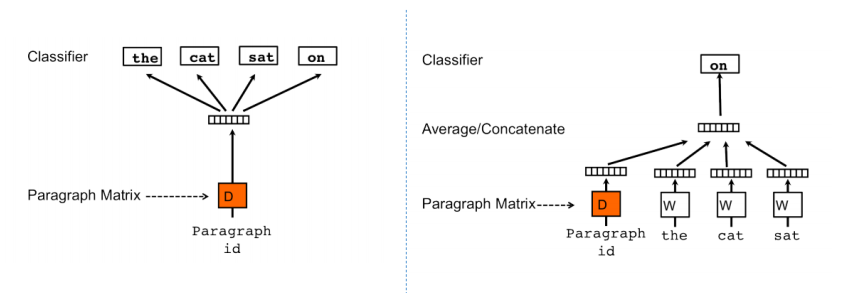

Define models with recomemmended hyperparameters:

In [ ]:
workers = multiprocessing.cpu_count() - 1  # leave one core for the OS & other stuff

# PV-DBOW: paragraph vector in distributed bag of words mode (~skip-gram)
model_dbow = Doc2Vec(
    dm=0, dbow_words=1,  # dbow_words=1 to train word vectors at the same time too, not only DBOW
    vector_size=300, window=3, epochs=15, workers=workers, min_count=20,
)

# PV-DMC: paragraph vector in distributed memory mode (~CBOW)
model_dmc = Doc2Vec(
    dm=1, cbow_mean=0, dm_mean=0,  # DMC. concatenative input-layer
    vector_size=300, window=3, epochs=15, workers=workers, min_count=20,
)

# PV-DMM:
model_dmm = Doc2Vec(
    dm=1, dm_mean=1,  # DMM. use average of context word vectors to train DM
    vector_size=300, window=3, epochs=15, workers=workers, min_count=20,
)

2022-08-01 17:05:52,741 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow+w,d300,n5,w3,mc20,s0.001,t7>', 'datetime': '2022-08-01T17:05:52.741538', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2022-08-01 17:05:52,744 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/s,d300,n5,w3,mc20,s0.001,t7>', 'datetime': '2022-08-01T17:05:52.744931', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2022-08-01 17:05:52,746 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d300,n5,w3,mc20,s0.001,t7>', 'datetime': '2022-08-01T17:05:52.746896', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


## Train models

In [ ]:
for model in [model_dbow, model_dmm, model_dmc]:
    # check hyperparameters
    print(model)
    # build vocabulary
    model.build_vocab(documents, progress_per=500000)
    # train
    model.train(documents, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

2022-08-01 17:05:52,758 : INFO : collecting all words and their counts
2022-08-01 17:05:52,762 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags


Doc2Vec<dbow+w,d300,n5,w3,mc20,s0.001,t7>


2022-08-01 17:06:42,540 : INFO : collected 3234908 word types and 147793 unique tags from a corpus of 147793 examples and 75261021 words
2022-08-01 17:06:42,543 : INFO : Creating a fresh vocabulary
2022-08-01 17:06:44,733 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=20 retains 202217 unique words (6.25% of original 3234908, drops 3032691)', 'datetime': '2022-08-01T17:06:44.733502', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-08-01 17:06:44,735 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=20 leaves 67988715 word corpus (90.34% of original 75261021, drops 7272306)', 'datetime': '2022-08-01T17:06:44.735297', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-08-01 17:06:46,029 : INFO : deleting th

Doc2Vec<dm/m,d300,n5,w3,mc20,s0.001,t7>


2022-08-01 18:03:05,452 : INFO : collected 3234908 word types and 147793 unique tags from a corpus of 147793 examples and 75261021 words
2022-08-01 18:03:05,454 : INFO : Creating a fresh vocabulary
2022-08-01 18:03:07,645 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=20 retains 202217 unique words (6.25% of original 3234908, drops 3032691)', 'datetime': '2022-08-01T18:03:07.645235', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-08-01 18:03:07,646 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=20 leaves 67988715 word corpus (90.34% of original 75261021, drops 7272306)', 'datetime': '2022-08-01T18:03:07.646691', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-08-01 18:03:08,963 : INFO : deleting th

Doc2Vec<dm/s,d300,n5,w3,mc20,s0.001,t7>


2022-08-01 18:38:31,657 : INFO : collected 3234908 word types and 147793 unique tags from a corpus of 147793 examples and 75261021 words
2022-08-01 18:38:31,659 : INFO : Creating a fresh vocabulary
2022-08-01 18:38:33,868 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=20 retains 202217 unique words (6.25% of original 3234908, drops 3032691)', 'datetime': '2022-08-01T18:38:33.868084', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-08-01 18:38:33,869 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=20 leaves 67988715 word corpus (90.34% of original 75261021, drops 7272306)', 'datetime': '2022-08-01T18:38:33.869747', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-08-01 18:38:35,175 : INFO : deleting th

Save models with class method:

In [ ]:
model_dbow.save('models/doc2vec_dbow.model')
model_dmm.save('models/doc2vec_dmm.model')
model_dmc.save('models/doc2vec_dmc.model')

2022-08-01 19:13:04,522 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'models/doc2vec_dbow.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-08-01T19:13:04.522491', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2022-08-01 19:13:04,526 : INFO : storing np array 'vectors' to models/doc2vec_dbow.model.dv.vectors.npy
2022-08-01 19:13:04,824 : INFO : storing np array 'vectors' to models/doc2vec_dbow.model.wv.vectors.npy
2022-08-01 19:13:05,259 : INFO : storing np array 'syn1neg' to models/doc2vec_dbow.model.syn1neg.npy
2022-08-01 19:13:06,494 : INFO : not storing attribute cum_table
2022-08-01 19:13:06,894 : INFO : saved models/doc2vec_dbow.model
2022-08-01 19:13:06,896 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'models/doc2vec_dmm.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'date

Compress models:

In [ ]:
with tarfile.open('models.tar.gz', "w:gz") as tar:
        tar.add('models/')

In [ ]:
!rm -rf 'models'